<a href="https://colab.research.google.com/github/ChintzRuparel/Stock-Market-Prediction-Using-LSTM/blob/main/NIFTYIT_Historical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [2]:
df = pd.read_csv('NIFTY-IT.csv') ##Source File to be changed here
df.head()

,Date,Last/Close,Open,High,Low,Volume
0,03/1/2000,45015.92,0.0,0.0,0.0,3777566.0
1,04/1/2000,48221.50,0.0,0.0,0.0,12128996.0
2,05/1/2000,46430.77,0.0,0.0,0.0,23400610.0
3,06/1/2000,44433.55,0.0,0.0,0.0,18408571.0
4,07/1/2000,41106.21,0.0,0.0,0.0,2762086.0


### preprocessing data set to perform analysis

In [3]:
df.shape

(5354, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5354 entries, 0 to 5353
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        5354 non-null   object 
 1   Last/Close  5354 non-null   float64
 2   Open        5354 non-null   float64
 3   High        5354 non-null   float64
 4   Low         5354 non-null   float64
 5   Volume      5344 non-null   float64
dtypes: float64(5), object(1)
memory usage: 251.1+ KB


In [5]:
df1 = df.iloc[:,1]
df1.head()

0    45015.92
1    48221.50
2    46430.77
3    44433.55
4    41106.21
Name: Last/Close, dtype: float64

In [6]:
df1.tail()

5349    29003.10
5350    29007.95
5351    28950.60
5352    28649.40
5353    28734.65
Name: Last/Close, dtype: float64

In [7]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    45015.92
1    48221.50
2    46430.77
3    44433.55
4    41106.21
Name: Last/Close, dtype: float64

Text(0, 0.5, 'stock price')

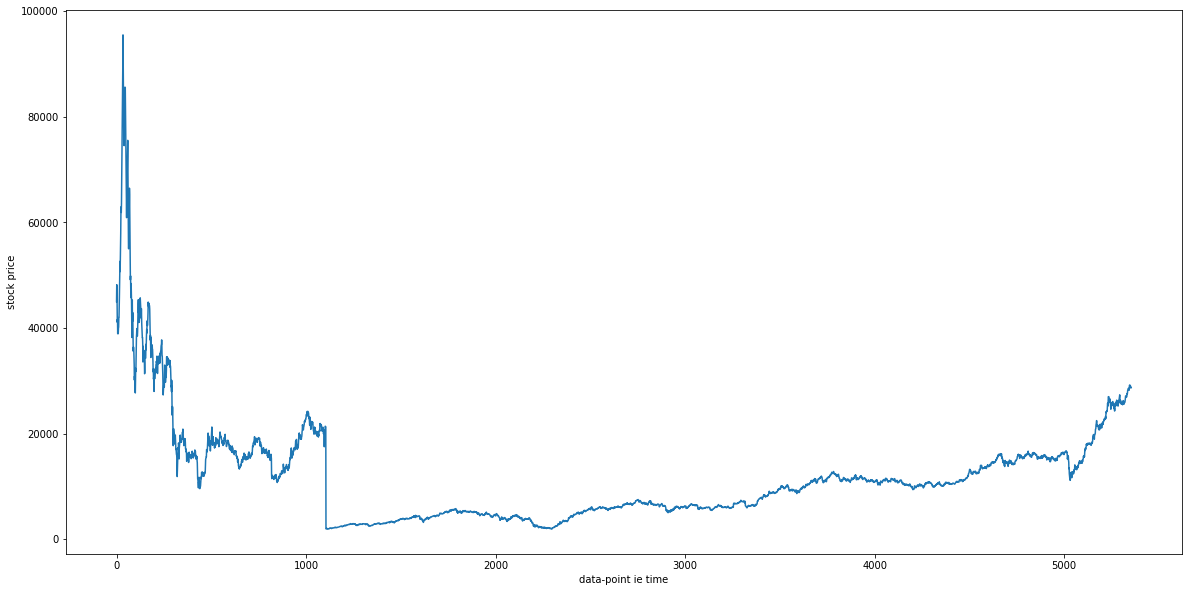

In [8]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

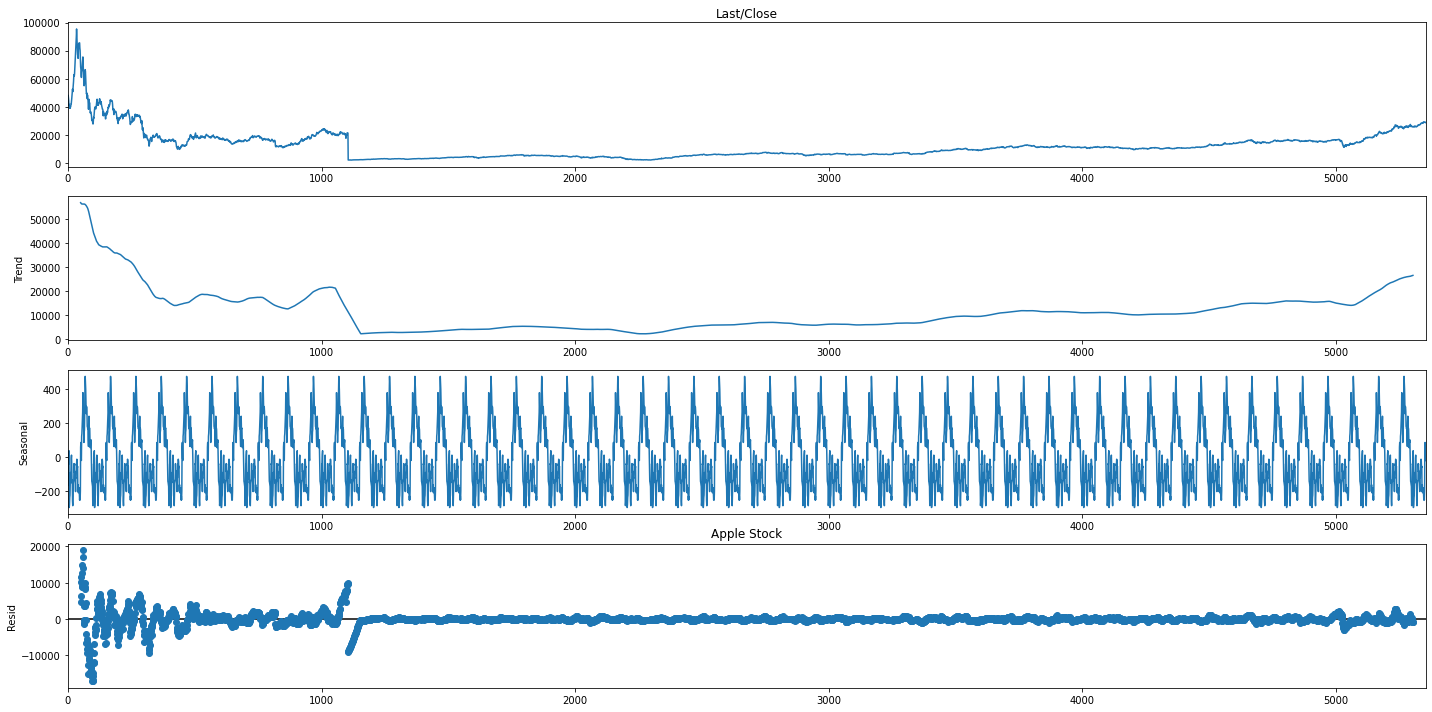

In [9]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [11]:
df1.shape

(5354,)

In [12]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.46031196]
 [0.4945794 ]
 [0.47543662]
 ...
 [0.28857476]
 [0.28535495]
 [0.28626627]]

 df1 present shape :  (5354, 1)


### splitting data (70/30)

In [14]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  3747
Test Size :  1607


In [15]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (3747, 1)
Test Data Shape:  (1607, 1)


### | windowing data set |

In [16]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [17]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3646, 100) (3646,)
(1506, 100) (1506,)


In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [23]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
57/57 [==============================] - 22s 261ms/step - loss: 0.0015 - val_loss: 1.0589e-04
Epoch 2/2
57/57 [==============================] - 14s 254ms/step - loss: 2.3437e-04 - val_loss: 3.2071e-05


In [24]:
y_pred = scaler.inverse_transform(model.predict(X_test))

48/48 [==============================] - 3s 44ms/step


In [25]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
y_pred[:5]

array([[11340.832],
       [11333.883],
       [11318.711],
       [11299.681],
       [11277.599]], dtype=float32)

In [27]:
y_test[:5]

array([[11238.6 ],
       [11142.95],
       [11401.7 ],
       [11227.15],
       [11049.35]])

### evaluation

In [28]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  529.7624186892709


In [29]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.9868785438048278


### visualization + plotting

114/114 [==============================] - 6s 53ms/step


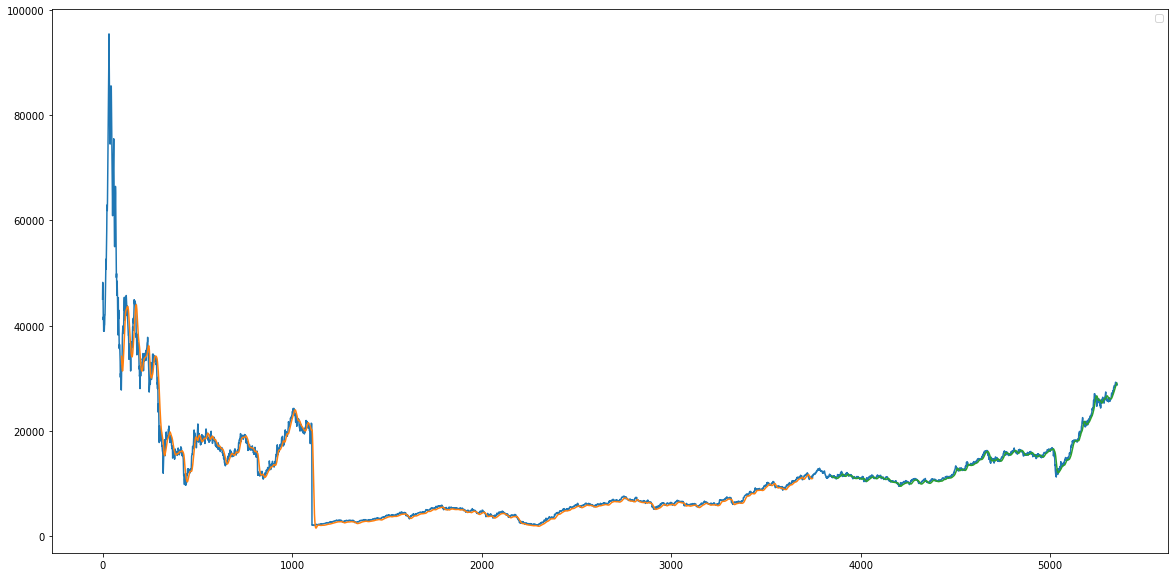

In [30]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [31]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
print(scaler.inverse_transform(lst_output))

[[29129.61260434]
 [29156.12819341]
 [29177.22134312]
 [29196.19291116]
 [29215.1226609 ]
 [29235.13689852]
 [29256.74580724]
 [29280.03302368]
 [29304.87588082]
 [29331.02068097]
 [29358.19142339]
 [29386.15671347]
 [29414.67958087]
 [29443.61505547]
 [29472.85440971]
 [29502.30564333]
 [29531.9325138 ]
 [29561.71550592]
 [29591.62674083]
 [29621.64949119]
 [29651.808848  ]
 [29682.08250815]
 [29712.47604743]
 [29742.99225371]
 [29773.61439969]
 [29804.34806112]
 [29835.17929859]
 [29866.1053242 ]
 [29897.12613795]
 [29928.21943676]]


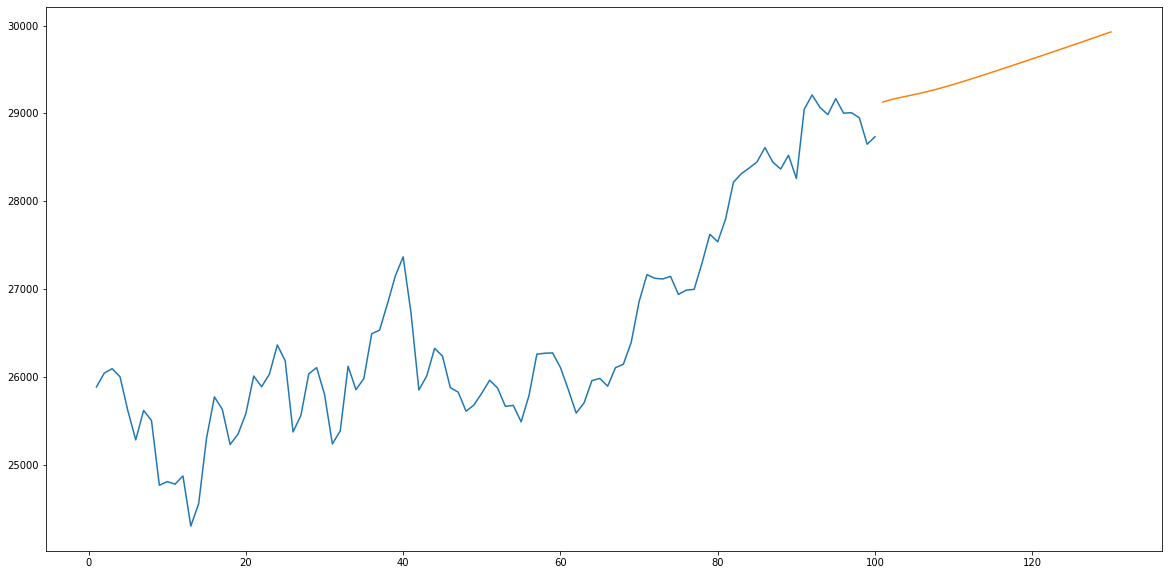

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))